# Colorado Water Rights Data Analysis

## The Problem

In a hypothetical scenario in which Colorado is facing a summer of extreme drought and the state has chosen to exercise greater authority over water diversions, the Colorado Water Conservation Board (CWCB) seeks to answer several general questions related to the beneficial use of water in Colorado, in addition to determining which water rights on several water sources need to be curtailed given the extreme state of drought.  

## Objectives

Q1. Determine what are the most common decreed uses among water rights in Colorado and create a visualization.

Q2. How many water rights have the Decreed Use of "All Beneficial Uses?"

Q3. Find the average diversion amounts and rates of water rights that can divert solely for household use year-round.

Q4. In a drought emergency scenario, the CWCB needs to send curtailment notices to all water rights holders diverting from several major tributaries of the Colorado River that have a priority date after December 31st, 1890. The tributaries include the Gunnison River, the Dolores River, the Green River, and the San Juan River. Identify those water rights and the different counties in which those rights have points of diversion.

Q5. The South Platte River has been experiencing reduced flows. The CWCB wants to identify which non-seasonal water rights on the South Platte River (that have municipal use as a decreed use) are affected, and the total amount/rates of allowed diversions under those rights.

### The Dataset

This analysis uses the Net Amounts Water Rights dataset available on the Colorado Department of Water Sources' website here:
https://data.colorado.gov/Water/DWR-Water-Right-Net-Amounts/acsg-f33s

The data dictionary is located in the link above, but the dictionary for beneficial use categories is located here:
https://dwr.state.co.us/Tools/WaterRights/TransactionsDataDictionary/GetDataDictionary
<a id="0"></a> <br>
### Table of Contents

1. [Data Cleaning](#1)
1. [Question 1](#2)
    1. [Question 1 Answer](#3)
1. [Question 2](#4)
    1. [Question 2 Answer](#5)
1. [Question 3](#6)
    1. [Question 3 Answer](#7)
1. [Question 4](#8)
    1. [Question 4 Answer](#9)
1. [Question 5](#10)
    1. [Question 5 Answer](#11)

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

In [86]:
# Listing only the relevant column names to import from the csv
col_list = [
             'Structure Name',
             'Structure Type',
             'Water Source',
             'County',
             'Appropriation Date',
             'Admin No',
             'Associated Case Numbers',
             'Decreed Uses',
             'Net Absolute',
             'Net Conditional',
             'Net APEX Absolute',
             'Net APEX Conditional',
             'Decreed Units',
             'Seasonal Limits'
            ]

# Importing data
df = pd.read_csv(r"D:\Water Rights Data\Colorado Water Rights\DWR_Water_Right_-_Net_Amounts (1).csv", usecols=col_list)
df.head()

,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits
0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No
1,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/30/1930,31257.29400,W1464-78,123458PX,0.0,0.0,2.33,0.0,C,No
2,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,10/30/1922,31760.26600,W1464-78,123458PX,0.0,0.0,28.80,0.0,A,No
3,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,08/04/1964,41854.00000,"10CW0019, 93CW0069",1458,0.0,0.0,0.00,50.0,C,No
4,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,05/20/1963,41727.41412,W1091-76,12458PX,0.0,0.0,0.00,864.0,C,No


In [87]:
# Observing the data type of each column
df.dtypes

Structure Name              object
Structure Type              object
Water Source                object
County                      object
Appropriation Date          object
Admin No                   float64
Associated Case Numbers     object
Decreed Uses                object
Net Absolute               float64
Net Conditional            float64
Net APEX Absolute          float64
Net APEX Conditional       float64
Decreed Units               object
Seasonal Limits             object
dtype: object

<a id="1"></a>
# Data Cleaning

- Check for duplicate rows
- Check for null values
- Convert the data types of the Appropriation Date column to datetime
- Trimming whitespace

[back to Table of Contents](#0)

In [88]:
# Removing approximately 200 duplicate rows
df = df.drop_duplicates()

In [89]:
# Checking the count of null values by column
df.isnull().sum()

Structure Name              0
Structure Type              0
Water Source                0
County                     99
Appropriation Date          0
Admin No                    0
Associated Case Numbers     0
Decreed Uses                0
Net Absolute                0
Net Conditional             0
Net APEX Absolute           0
Net APEX Conditional        0
Decreed Units               0
Seasonal Limits            16
dtype: int64

In [90]:
# Converting the data type of the appropriation date column to datetime
df.astype({'Appropriation Date': 'datetime64'}).dtypes

Structure Name                     object
Structure Type                     object
Water Source                       object
County                             object
Appropriation Date         datetime64[ns]
Admin No                          float64
Associated Case Numbers            object
Decreed Uses                       object
Net Absolute                      float64
Net Conditional                   float64
Net APEX Absolute                 float64
Net APEX Conditional              float64
Decreed Units                      object
Seasonal Limits                    object
dtype: object

In [91]:
# Trimming whitespace
df_obj = df.select_dtypes(['object'])

df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

<a id="2"></a>
## Q1. Create a visualization showing how many water rights fall under each decreed use category.

### Steps
- Determine how many different beneficial uses a water right can have
- Split the Decreed Uses column so each column has one character
- Replace these character values with the category name, create as new dataframe
- Unpivot split Decreed Use columns
- Left Join the main dataframe with this dataframe in order to conduct a groupby statement
- Group by decreed use category and count the number of observations
- Plot on bar graph

The Decreed Uses column displays all the different decreed uses a water right possesses. Each number/letter signifies a different use category. We will need to split the characters apart and then replace them by name.

In [92]:
# Checking the maximum number of beneficial uses a water right has in this dataset
df['Decreed Uses'].str.len().max()

19

In [93]:
# Since beneficial uses are represented by a single character, string values in the Decreed Uses column must be split & renamed
split_uses = (df['Decreed Uses'].str.split('', expand=True).rename(columns=lambda x: f"Decreed Use_{x}"))
split_uses

,Decreed Use_0,Decreed Use_1,Decreed Use_2,Decreed Use_3,Decreed Use_4,Decreed Use_5,Decreed Use_6,Decreed Use_7,Decreed Use_8,Decreed Use_9,...,Decreed Use_11,Decreed Use_12,Decreed Use_13,Decreed Use_14,Decreed Use_15,Decreed Use_16,Decreed Use_17,Decreed Use_18,Decreed Use_19,Decreed Use_20
0,,1,2,3,4,5,8,P,X,,...,None,None,None,None,None,None,None,None,None,None
1,,1,2,3,4,5,8,P,X,,...,None,None,None,None,None,None,None,None,None,None
2,,1,2,3,4,5,8,P,X,,...,None,None,None,None,None,None,None,None,None,None
3,,1,4,5,8,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,,1,2,4,5,8,P,X,,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172559,,1,2,3,4,5,8,P,X,,...,None,None,None,None,None,None,None,None,None,None
172560,,1,,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
172561,,5,6,A,,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
172562,,1,5,6,7,9,A,Q,,None,...,None,None,None,None,None,None,None,None,None,None


In [94]:
# Since we know that the max number of beneficial decreed uses is 19, we can drop Decreed Use_20, as well as Decreed Use_0
split_uses = split_uses.drop(columns=['Decreed Use_0','Decreed Use_20'])
split_uses.head()

,Decreed Use_1,Decreed Use_2,Decreed Use_3,Decreed Use_4,Decreed Use_5,Decreed Use_6,Decreed Use_7,Decreed Use_8,Decreed Use_9,Decreed Use_10,Decreed Use_11,Decreed Use_12,Decreed Use_13,Decreed Use_14,Decreed Use_15,Decreed Use_16,Decreed Use_17,Decreed Use_18,Decreed Use_19
0,1,2,3,4,5,8,P,X,,None,None,None,None,None,None,None,None,None,None
1,1,2,3,4,5,8,P,X,,None,None,None,None,None,None,None,None,None,None
2,1,2,3,4,5,8,P,X,,None,None,None,None,None,None,None,None,None,None
3,1,4,5,8,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,2,4,5,8,P,X,,None,None,None,None,None,None,None,None,None,None,None


In [95]:
# Creating a dictionary of beneficial use categories
use_dict = {'0' : 'STORAGE',
           '1' : 'IRRIGATION',
           '2' : 'MUNICIPAL',
           '3' : 'COMMERCIAL',
           '4' : 'INDUSTRIAL',
           '5' : 'RECREATION',
           '6' : 'FISHERY',
           '7' : 'FIRE',
           '8' : 'DOMESTIC',
           '9' : 'STOCK',
           'A' : 'AUGMENTATION',
           'B' : 'SUB-BASIN EXPORT',
           'C' : 'CHANGE OF USE RETURN FLOW',
           'E' : 'EVAPORATIVE',
           'F' : 'FEDERAL RESERVED',
           'G' : 'GEOTHERMAL',
           'H' : 'HOUSEHOLD USE ONLY',
           'K' : 'SNOW MAKING',
           'M' : 'MINIMUM STREAM FLOW',
           'P' : 'POWER GENERATION',
           'Q' : 'OTHER',
           'R' : 'RECHARGE',
           'S' : 'EXPORT FROM STATE',
           'T' : 'TRANSMOUNTAN EXPORT',
           'W' : 'WILDLIFE',
           'X' : 'ALL BENEFICIAL USES'
           }

use_dict

{'0': 'STORAGE',
 '1': 'IRRIGATION',
 '2': 'MUNICIPAL',
 '3': 'COMMERCIAL',
 '4': 'INDUSTRIAL',
 '5': 'RECREATION',
 '6': 'FISHERY',
 '7': 'FIRE',
 '8': 'DOMESTIC',
 '9': 'STOCK',
 'A': 'AUGMENTATION',
 'B': 'SUB-BASIN EXPORT',
 'C': 'CHANGE OF USE RETURN FLOW',
 'E': 'EVAPORATIVE',
 'F': 'FEDERAL RESERVED',
 'G': 'GEOTHERMAL',
 'H': 'HOUSEHOLD USE ONLY',
 'K': 'SNOW MAKING',
 'M': 'MINIMUM STREAM FLOW',
 'P': 'POWER GENERATION',
 'Q': 'OTHER',
 'R': 'RECHARGE',
 'S': 'EXPORT FROM STATE',
 'T': 'TRANSMOUNTAN EXPORT',
 'W': 'WILDLIFE',
 'X': 'ALL BENEFICIAL USES'}

In [96]:
# Replacing all single characters with their corresponding category name using the recently-created dictionary
split_uses = split_uses.replace(use_dict)
split_uses.head(10)

,Decreed Use_1,Decreed Use_2,Decreed Use_3,Decreed Use_4,Decreed Use_5,Decreed Use_6,Decreed Use_7,Decreed Use_8,Decreed Use_9,Decreed Use_10,Decreed Use_11,Decreed Use_12,Decreed Use_13,Decreed Use_14,Decreed Use_15,Decreed Use_16,Decreed Use_17,Decreed Use_18,Decreed Use_19
0,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None
1,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None
2,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None
3,IRRIGATION,INDUSTRIAL,RECREATION,DOMESTIC,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,IRRIGATION,MUNICIPAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None,None
5,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None
6,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None
7,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None
8,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None
9,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,,None,None,None,None,None,None,None,None,None,None


In [97]:
# Replacing blank spaces with null
split_uses = split_uses.replace('', np.NaN)

# Replacing None with NaN
split_uses = split_uses.fillna(value=np.NaN)
split_uses.head()

,Decreed Use_1,Decreed Use_2,Decreed Use_3,Decreed Use_4,Decreed Use_5,Decreed Use_6,Decreed Use_7,Decreed Use_8,Decreed Use_9,Decreed Use_10,Decreed Use_11,Decreed Use_12,Decreed Use_13,Decreed Use_14,Decreed Use_15,Decreed Use_16,Decreed Use_17,Decreed Use_18,Decreed Use_19
0,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IRRIGATION,INDUSTRIAL,RECREATION,DOMESTIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IRRIGATION,MUNICIPAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# Creating a temporary index value for use in the upcoming unpivot
split_uses.reset_index(level=0, inplace=True)


In [99]:
split_uses.dtypes
split_uses.head(10)

,index,Decreed Use_1,Decreed Use_2,Decreed Use_3,Decreed Use_4,Decreed Use_5,Decreed Use_6,Decreed Use_7,Decreed Use_8,Decreed Use_9,Decreed Use_10,Decreed Use_11,Decreed Use_12,Decreed Use_13,Decreed Use_14,Decreed Use_15,Decreed Use_16,Decreed Use_17,Decreed Use_18,Decreed Use_19
0,0,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,IRRIGATION,INDUSTRIAL,RECREATION,DOMESTIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,IRRIGATION,MUNICIPAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,IRRIGATION,MUNICIPAL,COMMERCIAL,INDUSTRIAL,RECREATION,DOMESTIC,POWER GENERATION,ALL BENEFICIAL USES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Creating a dimension table showing benefical use of each water right, using .melt to unpivot, with index sorted numerically
ben_uses = pd.melt(split_uses,
                     id_vars=['index'],
                     value_vars=[ 'Decreed Use_1',
                                  'Decreed Use_2',
                                  'Decreed Use_3',
                                  'Decreed Use_4',
                                  'Decreed Use_5',
                                  'Decreed Use_6',
                                  'Decreed Use_7',
                                  'Decreed Use_8',
                                  'Decreed Use_9',
                                  'Decreed Use_10',
                                  'Decreed Use_11',
                                  'Decreed Use_12',
                                  'Decreed Use_13',
                                  'Decreed Use_14',
                                  'Decreed Use_15',
                                  'Decreed Use_16',                                
                                  'Decreed Use_17',
                                  'Decreed Use_18',
                                  'Decreed Use_19'           
                     ], var_name= 'use_number', value_name='Beneficial_Use').dropna().sort_values(by=['index'])
ben_uses.head(20)

,index,use_number,Beneficial_Use
0,0,Decreed Use_1,IRRIGATION
172296,0,Decreed Use_2,MUNICIPAL
516888,0,Decreed Use_4,INDUSTRIAL
689184,0,Decreed Use_5,RECREATION
861480,0,Decreed Use_6,DOMESTIC
1033776,0,Decreed Use_7,POWER GENERATION
1206072,0,Decreed Use_8,ALL BENEFICIAL USES
344592,0,Decreed Use_3,COMMERCIAL
516889,1,Decreed Use_4,INDUSTRIAL
861481,1,Decreed Use_6,DOMESTIC


In [101]:
# Checking that a water right has unique uses
ben_uses[ben_uses['index'] == 4]

,index,use_number,Beneficial_Use
1033780,4,Decreed Use_7,ALL BENEFICIAL USES
344596,4,Decreed Use_3,INDUSTRIAL
4,4,Decreed Use_1,IRRIGATION
172300,4,Decreed Use_2,MUNICIPAL
861484,4,Decreed Use_6,POWER GENERATION
689188,4,Decreed Use_5,DOMESTIC
516892,4,Decreed Use_4,RECREATION


In [102]:
# Checking the dataframe's shape
ben_uses.shape

(434498, 3)

In [103]:
# Refamiliarizing with the main datafram
df.head(20)

,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits
0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No
1,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/30/1930,31257.29400,W1464-78,123458PX,0.0,0.0,2.33,0.0,C,No
2,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,10/30/1922,31760.26600,W1464-78,123458PX,0.0,0.0,28.80,0.0,A,No
3,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,08/04/1964,41854.00000,"10CW0019, 93CW0069",1458,0.0,0.0,0.00,50.0,C,No
4,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,05/20/1963,41727.41412,W1091-76,12458PX,0.0,0.0,0.00,864.0,C,No
5,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/01/1930,33782.29371,W1464-78,123458PX,0.0,0.0,20.70,0.0,A,No
6,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/03/1955,39254.38504,W1464-78,123458PX,0.0,0.0,8.50,0.0,A,No
7,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,0.50,0.0,C,No
8,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,09/23/1929,31626.29120,W1464-78,123458PX,0.0,0.0,10.00,0.0,A,No
9,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/03/1955,39254.38504,W1464-78,123458PX,0.0,0.0,0.60,0.0,C,No


In [104]:
# Creating an index column for the main dataframe for merging the main dataframe with the beneficial uses dataframe
df.reset_index(level=0, inplace=True)
df.head()

,index,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits
0,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No
1,1,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/30/1930,31257.29400,W1464-78,123458PX,0.0,0.0,2.33,0.0,C,No
2,2,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,10/30/1922,31760.26600,W1464-78,123458PX,0.0,0.0,28.80,0.0,A,No
3,3,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,08/04/1964,41854.00000,"10CW0019, 93CW0069",1458,0.0,0.0,0.00,50.0,C,No
4,4,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,05/20/1963,41727.41412,W1091-76,12458PX,0.0,0.0,0.00,864.0,C,No


In [105]:
# Merging both dataframes with a left join
merged = pd.merge(left=df, right=ben_uses, how='left', left_on='index', right_on='index')

In [106]:
merged = merged.sort_values(by=['index'])
merged.head(20)

,index,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits,use_number,Beneficial_Use
0,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_1,IRRIGATION
1,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_2,MUNICIPAL
2,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_4,INDUSTRIAL
3,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_5,RECREATION
4,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_6,DOMESTIC
5,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_7,POWER GENERATION
6,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_8,ALL BENEFICIAL USES
7,0,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/25/1895,19252.16612,W1464-78,123458PX,0.0,0.0,8.00,0.0,A,No,Decreed Use_3,COMMERCIAL
15,1,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/30/1930,31257.29400,W1464-78,123458PX,0.0,0.0,2.33,0.0,C,No,Decreed Use_5,RECREATION
14,1,COLORADO UTILITIES DITCH AND PIPELINE AP,Pipeline,YAMPA RIVER,ROUTT,06/30/1930,31257.29400,W1464-78,123458PX,0.0,0.0,2.33,0.0,C,No,Decreed Use_7,POWER GENERATION


<a id="3"></a>
## Q1 Answer

<Axes: title={'center': 'Number of Rights by Decreed Use Category'}, xlabel='Beneficial_Use', ylabel='Number_of_Water_Rights'>

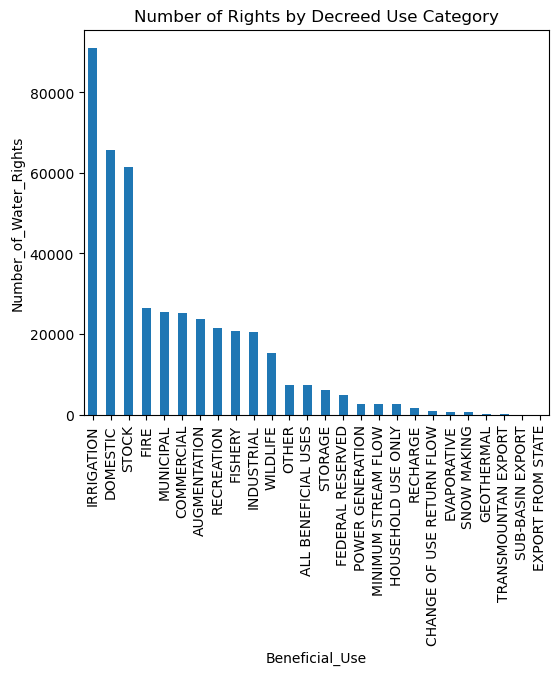

In [107]:
# Grouping by Beneficial use category to observe the most common uses of water
use_counts = merged.groupby(by=['Beneficial_Use']).count().filter(items=['index']).sort_values(by=['index'], ascending=False)

# Renaming the count column for readability
use_counts = use_counts.rename(columns={'index': 'Number_of_Water_Rights'})

# Plots a bar graph
use_counts.plot(kind='bar', title='Number of Rights by Decreed Use Category', ylabel='Number_of_Water_Rights',
         xlabel='Beneficial_Use', figsize=(6, 5), legend=False)

The most common type of decreed beneficial use among water rights in Colorado is irrigation, at approximately 90,000 water rights.

[back to Table of Contents](#0)

<a id="4"></a>
## Q2. How many water rights have the Decreed Use of "All Beneficial Uses?"

### Steps
- Group by decreed use category and count

In [108]:
# Using the previously established group-by dataframe
use_counts

,Number_of_Water_Rights
Beneficial_Use,
IRRIGATION,91017
DOMESTIC,65567
STOCK,61488
FIRE,26557
MUNICIPAL,25539
COMMERCIAL,25242
AUGMENTATION,23784
RECREATION,21580
FISHERY,20713


<a id="5"></a>
## Q2 Answer:

7,289 water rights have "all beneficial uses" listed as a decreed use.

[back to Table of Contents](#0)

<a id="6"></a>
## Q3. Find the average diversion amounts and rates of water rights that can divert solely for household use year-round.

### Steps

- Refer back to the original dataframe
- Use string-contains to isolate only rows that contain the appropriate character in the column Decreed Uses 

In [109]:
household_use_only = df[
                        (df['Decreed Uses'] == 'H') &
                        (df['Seasonal Limits'] == 'No')].filter(items= ['Decreed Uses',
                                                                  'Net Absolute',
                                                                  'Net Conditional',
                                                                  'Net APEX Absolute',
                                                                  'Net APEX Conditional',
                                                                  'Decreed Units'
                                                                 ])
household_use_only.head(20)

,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units
9344,H,0.0220,0.0,0.0,0.0,C
9451,H,0.0240,0.0,0.0,0.0,C
10735,H,0.0200,0.0,0.0,0.0,C
10973,H,0.0330,0.0,0.0,0.0,C
10985,H,0.0130,0.0,0.0,0.0,C
11184,H,1.0000,0.0,0.0,0.0,A
12088,H,0.0067,0.0,0.0,0.0,C
12184,H,0.0110,0.0,0.0,0.0,C
13280,H,0.0045,0.0,0.0,0.0,C
13318,H,0.0044,0.0,0.0,0.0,C


In [110]:
household_use_only_cfs = household_use_only[household_use_only['Decreed Units'] == 'C']

household_use_only_af = household_use_only[household_use_only['Decreed Units'] == 'A']

In [111]:
# Checking for the mean and outliers for cfs-decreed rights
household_use_only_cfs.describe()

,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional
count,1915.000000,1915.000000,1915.000000,1915.000000
mean,0.011992,0.005981,0.000445,0.000481
std,0.011868,0.020053,0.003598,0.006559
min,0.000000,0.000000,0.000000,0.000000
25%,0.002200,0.000000,0.000000,0.000000
50%,0.008800,0.000000,0.000000,0.000000
75%,0.018950,0.000000,0.000000,0.000000
max,0.101900,0.500000,0.055500,0.133600


array([[<Axes: title={'center': 'Net Absolute'}>,
        <Axes: title={'center': 'Net Conditional'}>],
       [<Axes: title={'center': 'Net APEX Absolute'}>,
        <Axes: title={'center': 'Net APEX Conditional'}>]], dtype=object)

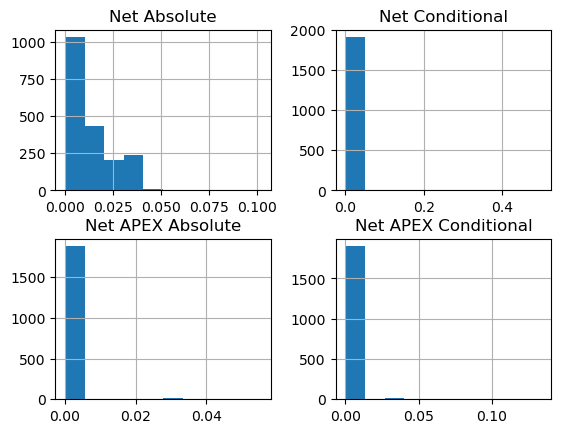

In [112]:
# Creating histograms of each diversion rate category for cfs to check for outliers
household_use_only_cfs.hist(bins=10)

In [113]:
# Checking for the mean and outliers for af-decreed rights
household_use_only_af.describe()

,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional
count,83.000000,83.000000,83.000000,83.000000
mean,4.073669,0.196196,0.007265,0.095282
std,28.008436,0.554778,0.033157,0.159161
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.210000,0.334650,0.000000,0.174200
max,240.000000,4.700000,0.269000,0.700000


array([[<Axes: title={'center': 'Net Absolute'}>,
        <Axes: title={'center': 'Net Conditional'}>],
       [<Axes: title={'center': 'Net APEX Absolute'}>,
        <Axes: title={'center': 'Net APEX Conditional'}>]], dtype=object)

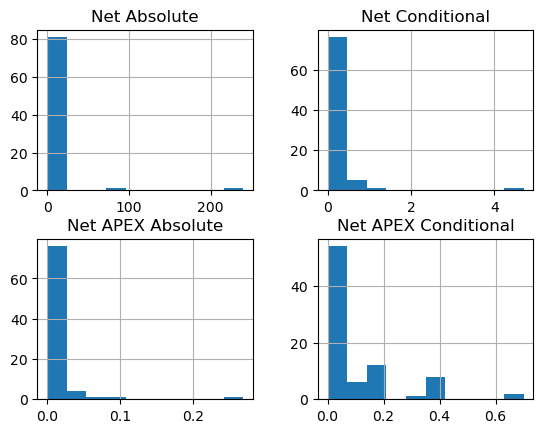

In [114]:
# Creating histograms of each diversion amount category for acre-feet to check for outliers
household_use_only_af.hist(bins=10)

<a id="7"></a>
## Q3 Answer:

There are 2004 water rights that have household use as their sole decreed use.

### Rights Measured in CFS

1918 rights are measured in cfs. The average diversion rates of these rights are:
- Net Absolute - 0.012 cfs
- Net Conditional - 0.006 cfs
- Net APEX Absolute - 0.0004 cfs
- Net APEX Conditional - 0.0004 cfs

Since the coefficients of variation are high for each category (the standard deviation divided by the mean), the medians may better describe the center of these distributions.

### Rights Measured in AF

86 rights are measure in acre-feet. The total diversion amounts of these rights are:
- Net Absolute - 3.931 af
- Net Conditional - 0.19 af
- Net APEX Absolute - 0.008 af
- Net APEX Conditional - 0.096 af

Given the presence of outliers and large standard deviations, the medians may more accurately describe these distributions as well. Exploring the outlier (completed below) in the net absolute category reveals how one right could skew the data: a well-field that can divert up to 240 acre-feet.

[back to Table of Contents](#0)

In [115]:
# Exploring the outlier amoung water rights that are household-use only and measured in acre-feet
df[
    (df['Decreed Uses'] == 'H') &
    (df['Decreed Units'] == 'A') & 
    (df['Net Absolute'] == 240)   
]

,index,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits
165889,166151,HI-POINT INMAN NNT ARAPAHOE,Well Field,GROUNDWATER: ARAPAHOE,EL PASO,07/31/2015,60477.0,15CW3035,H,240.0,0.0,0.0,0.0,A,No


<a id="8"></a>
## Q4. In a drought emergency scenario, the CWCB needs to send curtailment notices to all water rights holders diverting from several major tributaries of the Colorado River, that have a priority date after December 31st, 1890. The tributaries include the Gunnison River, the Dolores River, the Green River, and the San Juan River. Identify those water rights and the different counties in which those rights have points of diversion.

### Steps

- Create list of tributaries
- Select list and priority date cutoff from main dataframe

In [116]:
# Creating a list of the relevant tributaries
col_river_tribut = ['GUNNISON RIVER',
                   'DOLORES RIVER',
                   'GREEN RIVER',
                   'SAN JUAN RIVER']

# Selecting the values that match the tributary list and have a priority date after December 31st, 1946.
curtailed_rights = df[
                                (df['Water Source'].isin(col_river_tribut)) &
                                (df['Appropriation Date'] > '12/31/1890')
                                ].sort_values(by=['Appropriation Date'])
curtailed_rights['Water Source'].unique()

curtailed_rights

,index,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits
73539,73567,K O HARMAN DITCH NO 1,Ditch,SAN JUAN RIVER,ARCHULETA,12/31/1892,15706.00000,W0019,1,0.3300,0.0,0.0,0.0,C,No
119910,120020,KELMEL OWENS NO 1 DITCH,Ditch,GUNNISON RIVER,GUNNISON,12/31/1892,15706.00000,CA5839,1,3.7500,0.0,0.0,0.0,C,No
167403,167667,FRANK ADAMS NO 1 DITCH,Ditch,GUNNISON RIVER,GUNNISON,12/31/1892,15706.00000,CA5840,1,1.8750,0.0,0.0,0.0,C,No
136020,136146,GOULD & MORIARITY DITCH,Ditch,DOLORES RIVER,MONTEZUMA,12/31/1894,30667.16436,CA0967,189Q,1.0000,0.0,0.0,0.0,C,No
136844,136971,LINDSTROM DITCH,Ditch,DOLORES RIVER,MONTEZUMA,12/31/1894,16436.00000,CA0967,1,4.5000,0.0,0.0,0.0,C,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162992,163253,BEAVER SPRING,Spring,DOLORES RIVER,MONTROSE,12/31/2015,60630.00000,15CW3116,W,0.0022,0.0,0.0,0.0,C,No
163111,163372,GENESIS SPRING,Spring,DOLORES RIVER,MONTROSE,12/31/2015,60630.00000,15CW3116,W,0.0006,0.0,0.0,0.0,C,No
163447,163708,WET JENNY SPRING,Spring,DOLORES RIVER,MONTROSE,12/31/2015,60630.00000,15CW3116,W,0.0006,0.0,0.0,0.0,C,No
164932,165193,STAG SPRING,Spring,DOLORES RIVER,MONTROSE,12/31/2015,60630.00000,15CW3116,W,0.0011,0.0,0.0,0.0,C,No


In [117]:
# Identifying the counties in which these rights are situated
curtailed_rights['County'].unique()

array(['ARCHULETA', 'GUNNISON', 'MONTEZUMA', 'MONTROSE', 'DELTA',
       'SAN MIGUEL', 'DOLORES', 'MESA', 'MOFFAT'], dtype=object)

<a id="9"></a>
## Q4 Answer:

There are 86 water rights with a priority date after December 31st, 1890 that need to be sent curtailment notices on Gunnison, Dolores, Green, and San Juan Rivers. These rights are situated across nine different counties: Archuleta, Gunnison, Montezuma, Montrose, Delta, San Miguel, Dolores, Mesa, and Moffat.

[back to Table of Contents](#0)

<a id="10"></a>
## Q5. The South Platte River has been experiencing reduced flows. The CWCB wants to identify which non-seasonal water rights on the South Platte River that have municipal use as a decreed use are impacted, and the total amount/rates of allowed diversions under those rights.

### Steps

- Refer back to the merged dataframe containing split decreed use categories
- Select rows that have municipal use as a beneficial use, water source as the South Platte River, and Seasonal Limits as no
- Create separate dataframes for rights measured in cfs vs. acre-feet
- Aggregate both dataframes to get the total amounts for each diversion rate/amount category

In [118]:
# Selecting rows that match the requested criteria
curtailed_s_plat = merged[
    (merged['Beneficial_Use'] == 'MUNICIPAL') &
    (merged['Water Source'] == 'SOUTH PLATTE RIVER') &
    (merged['Seasonal Limits'] == 'No')
            ]
curtailed_s_plat.head(20)

,index,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits,use_number,Beneficial_Use
695,338,RIVERSIDE CANAL,Ditch,SOUTH PLATTE RIVER,WELD,04/29/2016,60750.00000,16CW3059,123489A,0.0000,0.0000,0.0,104.00,C,No,Decreed Use_2,MUNICIPAL
966,509,RR RES,Reservoir,SOUTH PLATTE RIVER,MORGAN,12/03/1987,50375.00000,"87CW0312, 96CW0042",12348AQ,13.0100,5.9900,0.0,0.00,A,No,Decreed Use_2,MUNICIPAL
1263,687,THORNTON PUMP STA 3A PIT,Reservoir,SOUTH PLATTE RIVER,WELD,12/31/1986,50038.00000,86CW0403,2X,0.0000,1030.0000,0.0,0.00,A,No,Decreed Use_1,MUNICIPAL
1954,1130,VANCIL RES,Reservoir,SOUTH PLATTE RIVER,MORGAN,06/17/1986,50403.49841,"96CW0236, 88CW0221",124589ARW,1359.0000,591.0000,0.0,0.00,A,No,Decreed Use_2,MUNICIPAL
2250,1290,RIVERSIDE CANAL,Ditch,SOUTH PLATTE RIVER,WELD,06/17/1986,50403.49841,"96CW0236, 88CW0221",124589ARW,658.4000,341.6000,0.0,0.00,C,No,Decreed Use_2,MUNICIPAL
2370,1362,PREWITT INLET CANAL,Ditch,SOUTH PLATTE RIVER,MORGAN,04/23/2003,56613.55995,03CW0195,12379AR,0.0000,0.0000,0.0,100.00,C,No,Decreed Use_2,MUNICIPAL
2577,1490,WELD COUNTY RES,Reservoir,SOUTH PLATTE RIVER,WELD,07/02/1963,41455.00000,CA16704,1248,0.0000,350570.0000,0.0,0.00,A,No,Decreed Use_2,MUNICIPAL
2765,1602,WELDON VALLEY DITCH,Ditch,SOUTH PLATTE RIVER,WELD,08/22/2011,59038.00000,11CW0131,2,0.0000,0.0000,0.0,3.10,C,No,Decreed Use_1,MUNICIPAL
3131,1815,HIGHWAY 36 STORM WTR RES,Reservoir,SOUTH PLATTE RIVER,ADAMS,12/03/1987,50375.00000,"87CW0312, 96CW0042",12348Q,26.0999,46.2501,0.0,0.00,A,No,Decreed Use_2,MUNICIPAL
3222,1870,WILDCAT RES,Reservoir,SOUTH PLATTE RIVER,MORGAN,04/11/1908,45655.21285,W8098,124,0.0000,60500.0000,0.0,0.00,A,No,Decreed Use_2,MUNICIPAL


In [119]:
# Checking the dataframe's dimensions
curtailed_rights.shape

(86, 15)

In [120]:
# Creating a separate dataframe to examine rights measured in cfs
curtailed_s_plat_cfs = curtailed_s_plat[curtailed_s_plat['Decreed Units'] == 'C']
curtailed_s_plat_cfs

,index,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits,use_number,Beneficial_Use
695,338,RIVERSIDE CANAL,Ditch,SOUTH PLATTE RIVER,WELD,04/29/2016,60750.00000,16CW3059,123489A,0.0,0.0,0.0000,104.0,C,No,Decreed Use_2,MUNICIPAL
2250,1290,RIVERSIDE CANAL,Ditch,SOUTH PLATTE RIVER,WELD,06/17/1986,50403.49841,"96CW0236, 88CW0221",124589ARW,658.4,341.6,0.0000,0.0,C,No,Decreed Use_2,MUNICIPAL
2370,1362,PREWITT INLET CANAL,Ditch,SOUTH PLATTE RIVER,MORGAN,04/23/2003,56613.55995,03CW0195,12379AR,0.0,0.0,0.0000,100.0,C,No,Decreed Use_2,MUNICIPAL
2765,1602,WELDON VALLEY DITCH,Ditch,SOUTH PLATTE RIVER,WELD,08/22/2011,59038.00000,11CW0131,2,0.0,0.0,0.0000,3.1,C,No,Decreed Use_1,MUNICIPAL
3644,2132,RIVERSIDE CANAL,Ditch,SOUTH PLATTE RIVER,WELD,01/05/1996,53330.00000,96CW0020,124589AR,0.0,1000.0,0.0000,0.0,C,No,Decreed Use_2,MUNICIPAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433329,172187,HENDERSON-SMITH HEADGATE WELL 3,Well,SOUTH PLATTE RIVER,LOGAN,07/19/1886,13349.00000,00CW0253,12345678AP,0.0,0.0,1.0487,0.0,C,No,Decreed Use_2,MUNICIPAL
433437,172218,HENDERSON-SMITH HEADGATE WELL 3,Well,SOUTH PLATTE RIVER,LOGAN,07/15/1873,8597.00000,00CW0253,12345678AP,0.0,0.0,10.3440,0.0,C,No,Decreed Use_2,MUNICIPAL
433866,172344,HENDERSON-SMITH HEADGATE WELL 3,Well,SOUTH PLATTE RIVER,LOGAN,11/30/1880,11292.00000,00CW0253,12345678AP,0.0,0.0,12.5000,0.0,C,No,Decreed Use_2,MUNICIPAL
434138,172433,BINDER DIVERSION PIPELINE,Pipeline,SOUTH PLATTE RIVER,WELD,12/15/2016,60980.00000,16CW3195,2AR,0.0,0.0,0.0000,30.0,C,No,Decreed Use_1,MUNICIPAL


In [121]:
# Aggregating to get the total allowable diversion rates from the South Platte by diversion category
curtailed_s_plat_cfs.groupby(by='Beneficial_Use').sum(numeric_only=True)

,index,Admin No,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional
Beneficial_Use,,,,,,
MUNICIPAL,52677054,2.039842e+07,6797.0165,13296.45,7039.6683,26514.999


In [122]:
# Creating a separate dataframe to examine rights measured in af
curtailed_s_plat_af = curtailed_s_plat[curtailed_s_plat['Decreed Units'] == 'A']
curtailed_s_plat_af

,index,Structure Name,Structure Type,Water Source,County,Appropriation Date,Admin No,Associated Case Numbers,Decreed Uses,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional,Decreed Units,Seasonal Limits,use_number,Beneficial_Use
966,509,RR RES,Reservoir,SOUTH PLATTE RIVER,MORGAN,12/03/1987,50375.00000,"87CW0312, 96CW0042",12348AQ,13.0100,5.9900,0.000,0.0,A,No,Decreed Use_2,MUNICIPAL
1263,687,THORNTON PUMP STA 3A PIT,Reservoir,SOUTH PLATTE RIVER,WELD,12/31/1986,50038.00000,86CW0403,2X,0.0000,1030.0000,0.000,0.0,A,No,Decreed Use_1,MUNICIPAL
1954,1130,VANCIL RES,Reservoir,SOUTH PLATTE RIVER,MORGAN,06/17/1986,50403.49841,"96CW0236, 88CW0221",124589ARW,1359.0000,591.0000,0.000,0.0,A,No,Decreed Use_2,MUNICIPAL
2577,1490,WELD COUNTY RES,Reservoir,SOUTH PLATTE RIVER,WELD,07/02/1963,41455.00000,CA16704,1248,0.0000,350570.0000,0.000,0.0,A,No,Decreed Use_2,MUNICIPAL
3131,1815,HIGHWAY 36 STORM WTR RES,Reservoir,SOUTH PLATTE RIVER,ADAMS,12/03/1987,50375.00000,"87CW0312, 96CW0042",12348Q,26.0999,46.2501,0.000,0.0,A,No,Decreed Use_2,MUNICIPAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430959,171400,ARS RESERVOIR,Reservoir,SOUTH PLATTE RIVER,DOUGLAS,02/28/2018,61420.00000,18CW3039,2,0.0000,2200.0000,0.000,0.0,A,No,Decreed Use_1,MUNICIPAL
431136,171455,ERGER'S POND,Reservoir,SOUTH PLATTE RIVER,ADAMS,05/27/2008,57856.00000,08CW0105,2,0.0000,700.0000,0.000,0.0,A,No,Decreed Use_1,MUNICIPAL
432963,172071,BINDER RESERVOIR,Reservoir,SOUTH PLATTE RIVER,WELD,12/15/2016,60980.00000,16CW3195,2AR,0.0000,2450.0000,0.000,0.0,A,No,Decreed Use_1,MUNICIPAL
433534,172246,HENDERSON-SMITH HEADGATE WELL 3,Well,SOUTH PLATTE RIVER,LOGAN,12/31/1929,31423.29219,00CW0253,12345678AP,0.0000,0.0000,132.848,0.0,A,No,Decreed Use_2,MUNICIPAL


In [123]:
# Aggregating to get the total allowable diversion amounts from the South Platte by diversion category
curtailed_s_plat_af.groupby(by='Beneficial_Use').sum(numeric_only=True)

,index,Admin No,Net Absolute,Net Conditional,Net APEX Absolute,Net APEX Conditional
Beneficial_Use,,,,,,
MUNICIPAL,14760095,7.589688e+06,711576.2199,1.715888e+06,24467.8404,757542.4935


<a id="11"></a>
## Q5 Answer:

943 rights that have municipal use as a decreed use are impacted by reduced flows on the South Platte River.

768 rights are measured in cfs. The total diversion rates of these rights are:
- Net Absolute - 6,797 cfs
- Net Conditional - 13,296 cfs
- Net APEX Absolute - 7,049 cfs
- Net APEX Conditional - 26,515 cfs

175 rights are measure in acre-feet. The total diversion amounts of these rights are:
- Net Absolute - 711,576 af
- Net Conditional - 1.71 million af
- Net APEX Absolute - 24,468 af
- Net APEX Conditional - 757,542 af

[back to Table of Contents](#0)